<a href="https://colab.research.google.com/github/Borja-rg/idal_ia3/blob/main/Exercise_Penguins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score,precision_score,accuracy_score,recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from itertools import product
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [4]:
# Loading and cleaning data
dataset = sns.load_dataset('penguins')
dataset.dropna(inplace=True)
dataset.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [5]:
y = dataset.sex
X_full = dataset.drop(columns = 'sex')
X = pd.get_dummies(X_full)
X.drop(columns = ['species_Adelie','island_Biscoe'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7)

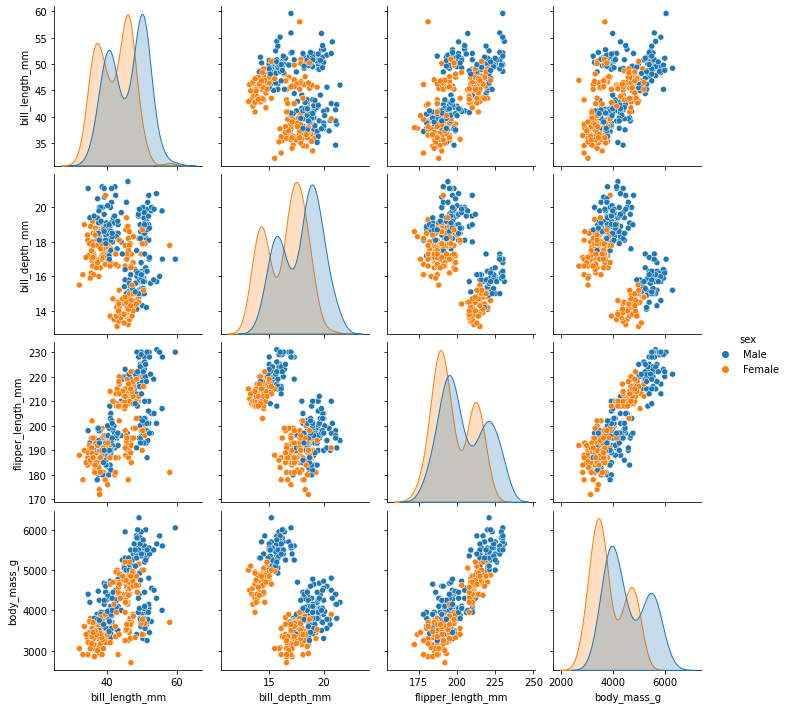

In [6]:
sns.pairplot(dataset,hue='sex')

###Decision Tree

In [7]:
model_tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
model_tree.fit(X_train,y_train)
model_tree.score(X_test,y_test)

0.87

In [8]:
max = 0
imax = 0
jmax = 0
for i in np.arange(1,15):
  for j in np.arange(1,15):
    tree_grid = DecisionTreeClassifier(criterion='entropy',max_depth = i, min_samples_leaf = j,random_state=0)
    tree_grid.fit(X_train,y_train)
    score = tree_grid.score(X_test,y_test) 
    bol = score>max
    if bol:
      max = score
      imax = i
      jmax = j
print(f'Tree grid with {imax} max depth and {jmax} min samples leaf: {max}')

Tree grid with 5 max depth and 3 min samples leaf: 0.92


In [9]:
model_tree_2 = DecisionTreeClassifier(criterion='entropy',max_depth = imax, min_samples_leaf = jmax,random_state=0)
model_tree_2.fit(X_train,y_train)
model_tree_2.score(X_train,y_train)

0.9484978540772532

In [10]:
cross_val_score(model_tree_2,X,y,cv=10)

array([0.85294118, 0.94117647, 0.82352941, 0.75757576, 0.75757576,
       0.96969697, 0.84848485, 0.87878788, 1.        , 0.87878788])

In [11]:
model_tree_3 = DecisionTreeClassifier(criterion='entropy',random_state=0)
params = {'max_depth': list(range(1,15)) ,'min_samples_leaf': list(range(1,15))}
cv_tree = GridSearchCV(model_tree_3,params,cv=10)

In [12]:
cv_tree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14

In [13]:
cv_tree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [14]:
optimal_tree = cv_tree.best_estimator_
optimal_tree.fit(X_train,y_train)
print(optimal_tree.score(X_train,y_train))
print(optimal_tree.score(X_test,y_test))

0.944206008583691
0.84


In [15]:
bagg_tree = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_depth = 11, min_samples_leaf = 2, random_state = 0,max_features=None)
bagg_tree.fit(X_train,y_train)
print(bagg_tree.score(X_train,y_train))
print(bagg_tree.score(X_test,y_test))

0.9785407725321889
0.94


In [17]:
# SCORING

y_pred = bagg_tree.predict(X_test)
print('roc_AUC_SCORE:',roc_auc_score(y_test,bagg_tree.predict_proba(X_test)[:,1]))
print('Accuracy_LR:',accuracy_score(y_test,y_pred))
print('Precision_LR:',precision_score(y_test,y_pred,average='weighted'))
print('Recall_LR:',recall_score(y_test,y_pred,average='weighted'))

roc_AUC_SCORE: 0.9672822159775191
Accuracy_LR: 0.94
Precision_LR: 0.9408483393357343
Recall_LR: 0.94


In [30]:
fpr,tpr,threshold=roc_curve(y_test,bagg_tree.predict_proba(X_test)[:,1],pos_label ='Male')
df_roc=pd.DataFrame({'fpr':fpr,'tpr':tpr,'thres':threshold})
px.line(df_roc,x='fpr',y='tpr',hover_data=['thres'])

In [29]:
df_roc_p = df_roc.copy()
df_roc_p['Classifier']='Random Forest'

###Logistic Regression

In [19]:
model_lin = LogisticRegression(solver='newton-cg',max_iter=10000,random_state=0)
model_lin.fit(X_train,y_train)
model_lin.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/sc

0.91

In [20]:
solvers = ['newton-cg','lbfgs','liblinear','sag','saga']
model_lin_2 = LogisticRegression(max_iter=1000,random_state=0)
params_lin = {'solver': solvers}
cv_lin = GridSearchCV(model_lin_2,params_lin,cv=10)

In [21]:
cv_lin.fit(X,y)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/sc

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
cv_lin.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
optimal_log = cv_lin.best_estimator_
optimal_log.fit(X_train,y_train)
print(optimal_log.score(X_train,y_train))
print(optimal_log.score(X_test,y_test))

0.9141630901287554
0.91


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/sc

In [24]:
bagged_log = BaggingClassifier(optimal_log,n_estimators = 100, random_state=0)
bagged_log.fit(X_train,y_train)
print(bagged_log.score(X_train,y_train))
print(bagged_log.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/sc

0.9141630901287554
0.91


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.6/dist-packages/sc

In [25]:
y_pred_2 = bagged_log.predict(X_test)
print('roc_AUC_SCORE:',roc_auc_score(y_test,bagged_log.predict_proba(X_test)[:,1]))
print('Accuracy_LR:',accuracy_score(y_test,y_pred_2))
print('Precision_LR:',precision_score(y_test,y_pred_2,average='weighted'))
print('Recall_LR:',recall_score(y_test,y_pred_2,average='weighted'))

roc_AUC_SCORE: 0.9618627057406663
Accuracy_LR: 0.91
Precision_LR: 0.9100563607085346
Recall_LR: 0.91


In [31]:
fpr,tpr,threshold=roc_curve(y_test,bagged_log.predict_proba(X_test)[:,1],pos_label ='Male')
df_roc_2=pd.DataFrame({'fpr':fpr,'tpr':tpr,'thres':threshold})
df_roc_p_2 = df_roc_2.copy()
df_roc_p_2['Classifier'] = 'Logistic Regression'
df_roc_all = pd.concat([df_roc_p,df_roc_p_2])
px.line(df_roc_all,x='fpr',y='tpr',hover_data=['thres'],color='Classifier')

###Naive Bayes

In [ ]:
model_NB = GaussianNB()
model_NB.fit(X_train,y_train)
model_NB.score(X_test,y_test)

0.79

###Support Vector Machines

In [ ]:
model_SVM = SVC()
model_SVM.fit(X_train,y_train)
model_SVM.score(X_test,y_test)

0.63